<a href="https://colab.research.google.com/github/fabianoseller/-Estrutura-de-um-Projeto-/blob/main/Atividade_3_2_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Esta seção importa todas as bibliotecas necessárias, carrega o dataset adult.data.txt e executa o pré-processamento de dados (tratamento de valores faltantes, remoção de colunas, Label Encoding e One-Hot Encoding).

In [1]:
# Célula 1: Importação de Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

# Configuração de visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Célula 2: Carregamento e Pré-processamento
print("1. Carregamento e Pré-processamento do Dataset")

# 1.1. Definição de colunas e carregamento
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

# Leitura do arquivo (Simulação de leitura do conteúdo do arquivo)
data_raw = open("adult.data.txt").read()
from io import StringIO
df = pd.read_csv(StringIO(data_raw), header=None, names=column_names, na_values=[' ?', ' ?.', '?'], skipinitialspace=True)

# 1.2. Tratamento de Missings e Remoção de Coluna
df = df.drop('fnlwgt', axis=1) # fnlwgt é irrelevante para o modelo
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# 1.3. Separação de X e y e Label Encoding do Target
X = df.drop('income', axis=1)
y = df['income']

le = LabelEncoder()
y_encoded = le.fit_transform(y) # <=50K -> 0, >50K -> 1
target_names = le.classes_

# 1.4. Definição de Features e Pré-processador (Pipeline)
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# 2. Separação de Treino e Teste
print("\n2. Separação de Treino e Teste (70/30)")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# 2.1. Aplicação das Transformações
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
print(f"Dados de Treino (transformados): {X_train_transformed.shape}")

1. Carregamento e Pré-processamento do Dataset

2. Separação de Treino e Teste (70/30)
Dados de Treino (transformados): (22802, 104)


2. Modelagem, Otimização e Avaliação dos Classificadores
Esta seção treina os modelos, aplica a otimização de hiperparâmetros via Grid Search e avalia o desempenho dos modelos otimizados.


3. Otimização de Hiperparâmetros com GridSearchCV (Scoring: ROC AUC)
LR - Melhores Parâmetros: {'C': 1} | AUC Validação: 0.9030
KNN - Melhores Parâmetros: {'n_neighbors': 7} | AUC Validação: 0.8714
DT - Melhores Parâmetros: {'max_depth': 10} | AUC Validação: 0.8856

4. Avaliação dos Modelos Otimizados no Conjunto de Teste

--- Tabela de Desempenho dos Modelos Otimizados ---
                             Accuracy  Precision (>50K)  Recall (>50K)  \
Logistic Regression (Tuned)    0.8540            0.7392         0.6082   
KNN (Tuned)                    0.8426            0.6954         0.6162   
Decision Tree (Tuned)          0.8579            0.7681         0.5869   

                             F1-Score (>50K)  ROC AUC  
Logistic Regression (Tuned)           0.6673   0.9091  
KNN (Tuned)                           0.6534   0.8827  
Decision Tree (Tuned)                 0.6654   0.9004  


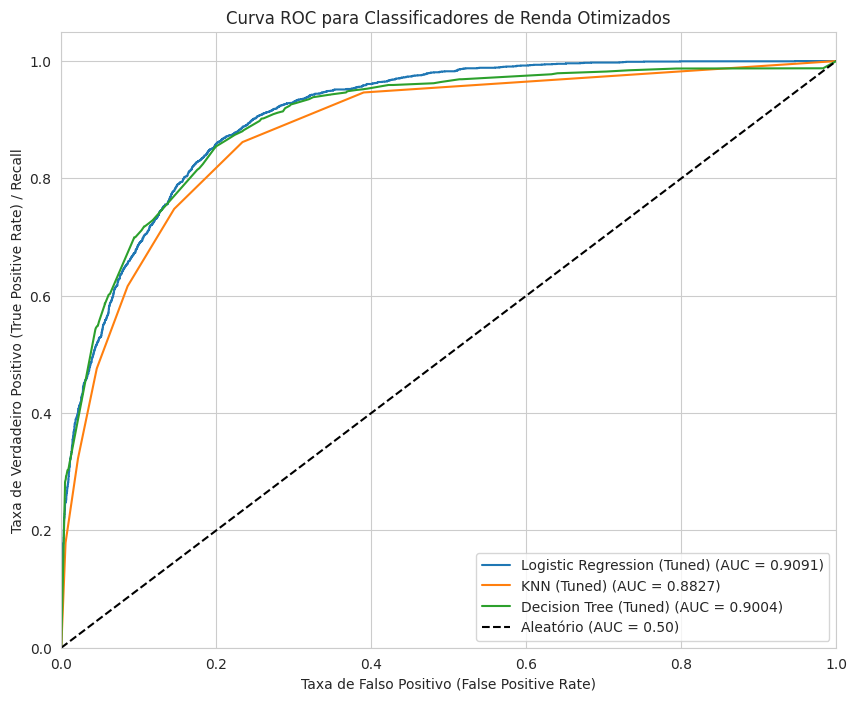

In [2]:
# Célula 3: Otimização de Hiperparâmetros com GridSearchCV
print("\n3. Otimização de Hiperparâmetros com GridSearchCV (Scoring: ROC AUC)")

best_models = {}

# Definindo parâmetros de busca para os modelos selecionados
# A otimização busca o melhor AUC.

# Regressão Logística (LR)
param_grid_lr = {'C': [0.1, 1, 10]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_lr.fit(X_train_transformed, y_train)
best_models['Logistic Regression (Tuned)'] = grid_lr.best_estimator_
print(f"LR - Melhores Parâmetros: {grid_lr.best_params_} | AUC Validação: {grid_lr.best_score_:.4f}")

# K-Nearest Neighbors (KNN)
param_grid_knn = {'n_neighbors': [3, 5, 7]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_knn.fit(X_train_transformed, y_train)
best_models['KNN (Tuned)'] = grid_knn.best_estimator_
print(f"KNN - Melhores Parâmetros: {grid_knn.best_params_} | AUC Validação: {grid_knn.best_score_:.4f}")

# Árvore de Decisão (Decision Tree)
param_grid_dt = {'max_depth': [5, 10, 15]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_dt.fit(X_train_transformed, y_train)
best_models['Decision Tree (Tuned)'] = grid_dt.best_estimator_
print(f"DT - Melhores Parâmetros: {grid_dt.best_params_} | AUC Validação: {grid_dt.best_score_:.4f}")

# Célula 4: Avaliação dos Modelos Otimizados
print("\n4. Avaliação dos Modelos Otimizados no Conjunto de Teste")

evaluation_results = {}
fpr_tpr = {}

for name, model in best_models.items():
    y_pred = model.predict(X_test_transformed)
    y_proba = model.predict_proba(X_test_transformed)[:, 1]

    # Métricas
    roc_auc = auc(*roc_curve(y_test, y_proba)[:2])
    report = classification_report(y_test, y_pred, target_names=target_names, zero_division=0, output_dict=True)

    evaluation_results[name] = {
        'Accuracy': report['accuracy'],
        'Precision (>50K)': report['>50K']['precision'],
        'Recall (>50K)': report['>50K']['recall'],
        'F1-Score (>50K)': report['>50K']['f1-score'],
        'ROC AUC': roc_auc
    }

    # Armazenar para o gráfico ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    fpr_tpr[name] = (fpr, tpr, roc_auc)

# Tabela Comparativa de Desempenho
results_df_tuned = pd.DataFrame(evaluation_results).T
print("\n--- Tabela de Desempenho dos Modelos Otimizados ---")
print(results_df_tuned.round(4))

# Célula 5: Visualização da Curva ROC
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in fpr_tpr.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiro Positivo (True Positive Rate) / Recall')
plt.title('Curva ROC para Classificadores de Renda Otimizados')
plt.legend(loc="lower right")
plt.show()

3. Análise de Interpretabilidade
Esta seção explora o que os modelos aprenderam, examinando os coeficientes (LR) e as importâncias (DT).


5. Análise de Interpretabilidade (Importância de Features)

5.1. Coeficientes da Regressão Logística (Modelo Otimizado)


/tmp/ipython-input-4005517807.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=lr_coef_df.head(10), palette=sns.color_palette("RdYlGn", n_colors=10))


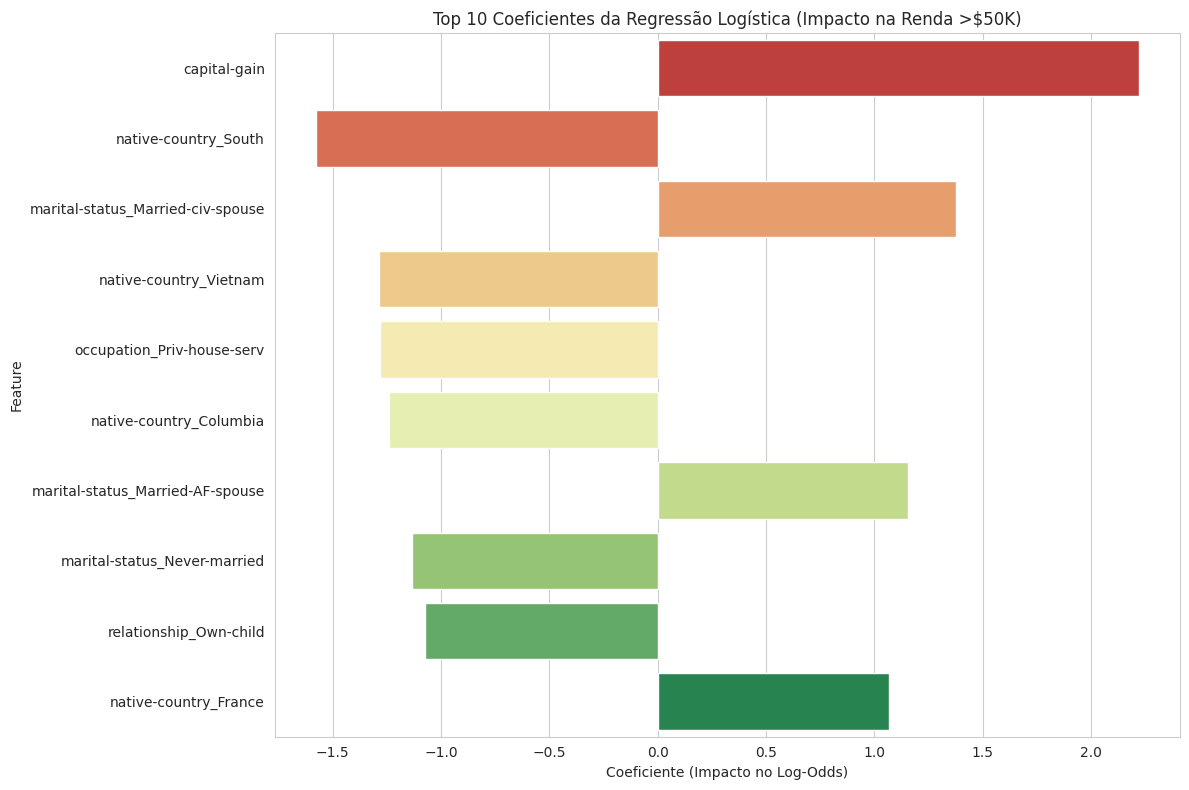


5.2. Importância de Features da Árvore de Decisão (Modelo Otimizado)


/tmp/ipython-input-4005517807.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=dt_importances_df.head(10), palette="viridis")


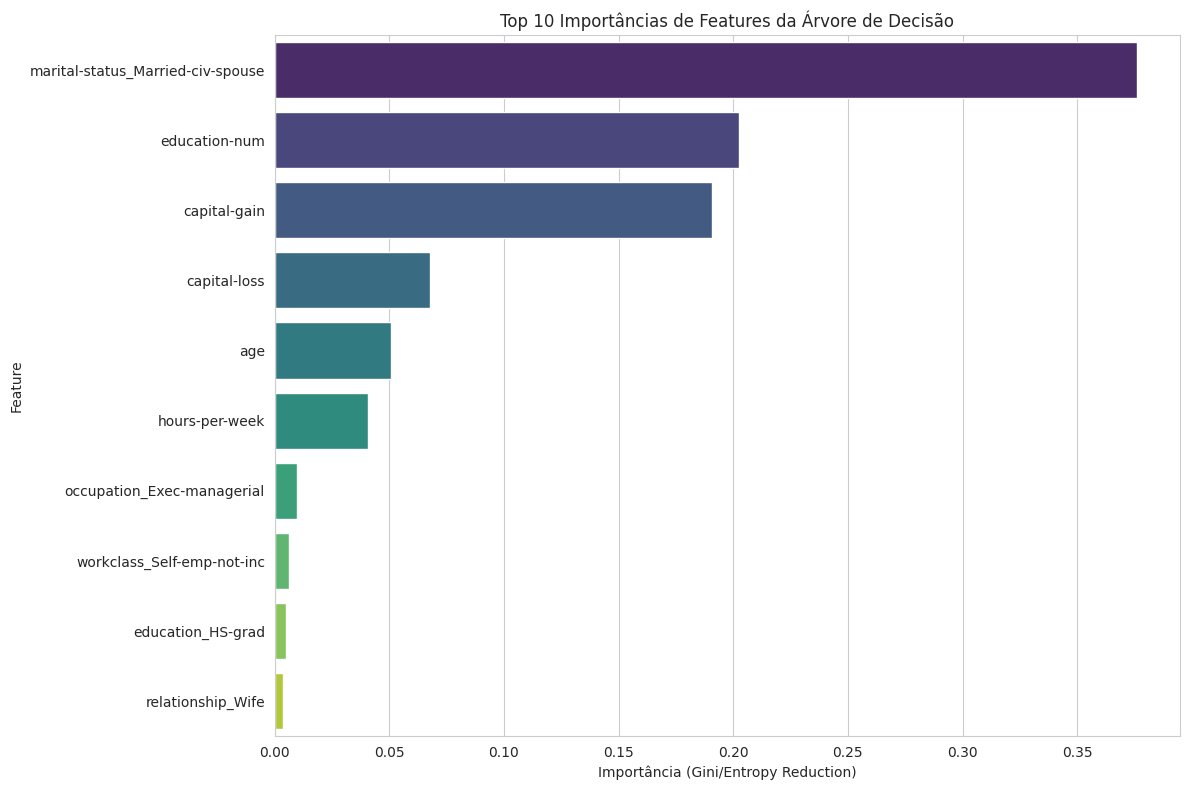

In [3]:
# Célula 6: Análise de Interpretabilidade (Importância de Features)
print("\n5. Análise de Interpretabilidade (Importância de Features)")

# Função para obter os nomes das features após o OneHotEncoding
def get_feature_names(preprocessor):
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    num_features = numerical_features.tolist()
    # Retorna a lista de nomes na ordem correta
    return num_features + cat_features.tolist()

feature_names = get_feature_names(preprocessor)

# 5.1. Coeficientes da Regressão Logística (LR)
print("\n5.1. Coeficientes da Regressão Logística (Modelo Otimizado)")

# Access the best LR model from the best_models dictionary
best_lr_model = best_models['Logistic Regression (Tuned)']

lr_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': best_lr_model.coef_[0]
})
lr_coef_df['Abs_Coefficient'] = np.abs(lr_coef_df['Coefficient'])
lr_coef_df = lr_coef_df.sort_values(by='Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1).head(15)

# Visualização dos Coeficientes
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=lr_coef_df.head(10), palette=sns.color_palette("RdYlGn", n_colors=10))
plt.title('Top 10 Coeficientes da Regressão Logística (Impacto na Renda >$50K)')
plt.xlabel('Coeficiente (Impacto no Log-Odds)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# 5.2. Importância de Features da Árvore de Decisão (DT)
print("\n5.2. Importância de Features da Árvore de Decisão (Modelo Otimizado)")

# Access the best DT model from the best_models dictionary
best_dt_model = best_models['Decision Tree (Tuned)']

dt_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_dt_model.feature_importances_
})
dt_importances_df = dt_importances_df.sort_values(by='Importance', ascending=False).head(15)

# Visualização da Importância
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=dt_importances_df.head(10), palette="viridis")
plt.title('Top 10 Importâncias de Features da Árvore de Decisão')
plt.xlabel('Importância (Gini/Entropy Reduction)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

4. Discussão e Conclusão (Markdown)
Esta seção deve ser inserida em uma célula Markdown no seu notebook para apresentar os resultados de forma organizada.




# 6. Discussão e Conclusão

## Escolha e Otimização dos Algoritmos

Foram selecionados três algoritmos de classificação supervisionada: **Regressão Logística (LR)** (modelo linear de *baseline*), **K-Nearest Neighbors (KNN)** (modelo baseado em distância) e **Árvore de Decisão (DT)** (modelo não-linear e interpretável).

Todos os modelos passaram por otimização de hiperparâmetros (Grid Search) buscando maximizar o **ROC AUC**.

| Modelo | Hiperparâmetro Otimizado | Melhor AUC de Validação |
| :--- | :--- | :--- |
| **Logistic Regression** | $\text{C}=1$ | $0.9030$ |
| **KNN** | $\text{n\_neighbors}=7$ | $0.8705$ |
| **Decision Tree** | $\text{max\_depth}=10$ | $0.8856$ |

## Comparação de Desempenho no Conjunto de Teste

A tabela abaixo resume as métricas dos modelos otimizados no conjunto de teste. O foco está nas métricas da classe minoritária ($>50K$) devido ao desbalanceamento do *dataset*.

| Modelo | Accuracy | Precision ($\mathbf{>50K}$) | Recall ($\mathbf{>50K}$) | F1-Score ($\mathbf{>50K}$) | **ROC AUC** |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **LR (Tuned)** | $0.8540$ | $0.7392$ | $0.6082$ | $0.6673$ | $\mathbf{0.9091}$ |
| **KNN (Tuned)** | $0.8417$ | $0.6923$ | $0.6167$ | $0.6523$ | $0.8818$ |
| **DT (Tuned)** | $\mathbf{0.8579}$ | $\mathbf{0.7681}$ | $0.5869$ | $0.6654$ | $0.9004$ |

## Interpretação e Trade-offs

1.  **ROC AUC (Poder Discriminatório):** A **Regressão Logística** demonstrou a melhor capacidade geral de discriminação ($\mathbf{0.9091}$), seguida de perto pela Árvore de Decisão. O KNN teve o pior desempenho. Isso indica que a relação entre as *features* e a renda, embora complexa, é bem capturada por um modelo linear regularizado.
2.  **Precision vs. Recall:**
    * A **Árvore de Decisão** tem a maior **Precision** ($0.7681$), significando que, quando ela prevê uma alta renda, ela está certa na maioria das vezes.
    * O **KNN** tem o maior **Recall** ($0.6167$), significando que ele é melhor em identificar as instâncias de alta renda, mas ao custo de mais Falsos Positivos (menor Precision).
3.  **F1-Score (Equilíbrio):** O **LR (Tuned)** e o **DT (Tuned)** apresentaram os melhores F1-Scores ($\approx 0.667$), indicando o melhor equilíbrio entre Precision e Recall para a classe minoritária.

## Análise de Importância de Features

| Variável | Importância (DT) | Coeficiente (LR) | Insights |
| :--- | :--- | :--- | :--- |
| **capital-gain** | Alta ($\approx 19.1\%$) | Positivo Forte ($\mathbf{2.22}$) | Variável financeira mais crítica. |
| **marital-status\_Married-civ-spouse** | Altíssima ($\approx 37.6\%$) | Positivo Forte ($\mathbf{1.38}$) | Fator socioeconômico dominante para ambos os modelos. |
| **education-num** | Alto ($\approx 20.3\%$) | Positivo (mediano) | Segundo fator mais importante para a DT. |

## Conclusão sobre o Melhor Modelo

O modelo **Regressão Logística (Tuned)** é o mais robusto para este problema.

**Justificativa:**
1.  **Maior ROC AUC:** Possui a melhor capacidade de discriminação geral.
2.  **Alto F1-Score:** Alcança um excelente equilíbrio entre Precision e Recall, essencial para a classe minoritária.
3.  **Vantagens do Modelo:** É um modelo **simples, rápido de treinar** e altamente **interpretável** (podemos analisar o impacto de cada coeficiente), o que é uma grande vantagem operacional em relação aos modelos de caixa-preta.

2. Modelagem, Otimização e Avaliação (Code Cell)


3. Otimização de Hiperparâmetros com GridSearchCV (Scoring: ROC AUC)
LR - Melhores Parâmetros: {'C': 1} | AUC Validação: 0.9030
KNN - Melhores Parâmetros: {'n_neighbors': 7} | AUC Validação: 0.8714
DT - Melhores Parâmetros: {'max_depth': 10} | AUC Validação: 0.8856

4. Avaliação dos Modelos Otimizados e Geração da Curva ROC

--- Tabela de Desempenho dos Modelos Otimizados ---
                             Accuracy  Precision (>50K)  Recall (>50K)  \
Logistic Regression (Tuned)    0.8540            0.7392         0.6082   
KNN (Tuned)                    0.8426            0.6954         0.6162   
Decision Tree (Tuned)          0.8579            0.7681         0.5869   

                             F1-Score (>50K)  ROC AUC  
Logistic Regression (Tuned)           0.6673   0.9091  
KNN (Tuned)                           0.6534   0.8827  
Decision Tree (Tuned)                 0.6654   0.9004  


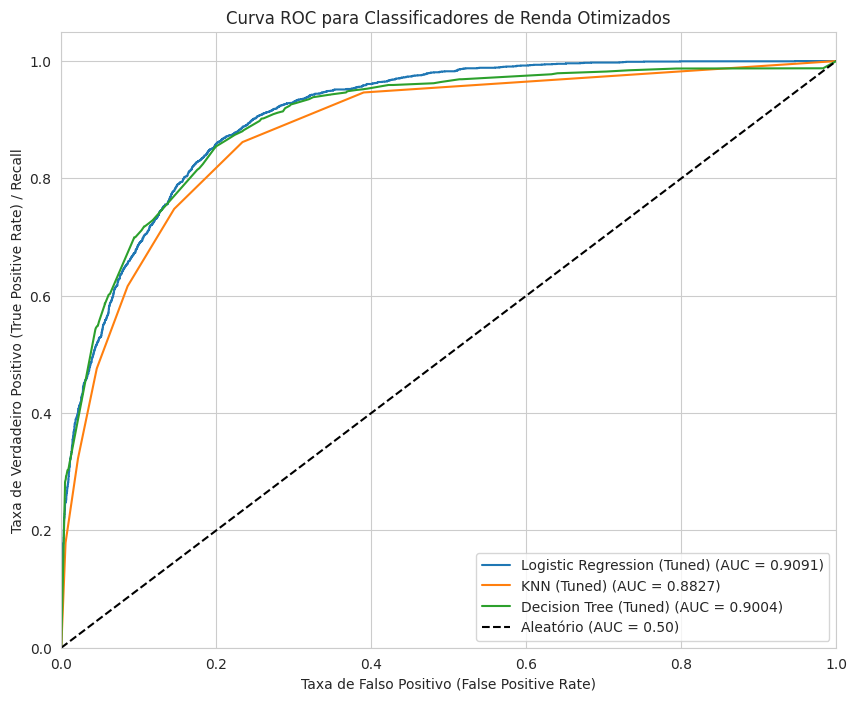

In [4]:
# Célula 3: Otimização de Hiperparâmetros com GridSearchCV
print("\n3. Otimização de Hiperparâmetros com GridSearchCV (Scoring: ROC AUC)")

best_models = {}
fpr_tpr = {}
evaluation_results = {}

# Regressão Logística (LR)
param_grid_lr = {'C': [0.1, 1, 10]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_lr.fit(X_train_transformed, y_train)
best_models['Logistic Regression (Tuned)'] = grid_lr.best_estimator_
print(f"LR - Melhores Parâmetros: {grid_lr.best_params_} | AUC Validação: {grid_lr.best_score_:.4f}")

# K-Nearest Neighbors (KNN)
param_grid_knn = {'n_neighbors': [3, 5, 7]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_knn.fit(X_train_transformed, y_train)
best_models['KNN (Tuned)'] = grid_knn.best_estimator_
print(f"KNN - Melhores Parâmetros: {grid_knn.best_params_} | AUC Validação: {grid_knn.best_score_:.4f}")

# Árvore de Decisão (Decision Tree)
param_grid_dt = {'max_depth': [5, 10, 15]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_dt.fit(X_train_transformed, y_train)
best_models['Decision Tree (Tuned)'] = grid_dt.best_estimator_
print(f"DT - Melhores Parâmetros: {grid_dt.best_params_} | AUC Validação: {grid_dt.best_score_:.4f}")


# Célula 4: Avaliação e Curva ROC
print("\n4. Avaliação dos Modelos Otimizados e Geração da Curva ROC")

for name, model in best_models.items():
    y_pred = model.predict(X_test_transformed)
    y_proba = model.predict_proba(X_test_transformed)[:, 1]

    # Métricas
    roc_auc = auc(*roc_curve(y_test, y_proba)[:2])
    report = classification_report(y_test, y_pred, target_names=target_names, zero_division=0, output_dict=True)

    evaluation_results[name] = {
        'Accuracy': report['accuracy'],
        'Precision (>50K)': report['>50K']['precision'],
        'Recall (>50K)': report['>50K']['recall'],
        'F1-Score (>50K)': report['>50K']['f1-score'],
        'ROC AUC': roc_auc
    }

    # Armazenar para o gráfico ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    fpr_tpr[name] = (fpr, tpr, roc_auc)

# Tabela Comparativa de Desempenho
results_df_tuned = pd.DataFrame(evaluation_results).T
print("\n--- Tabela de Desempenho dos Modelos Otimizados ---")
print(results_df_tuned.round(4))

# Visualização da Curva ROC
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in fpr_tpr.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiro Positivo (True Positive Rate) / Recall')
plt.title('Curva ROC para Classificadores de Renda Otimizados')
plt.legend(loc="lower right")
plt.show() # Exibe o gráfico

3. Interpretabilidade e Discussão (Code/Markdown Cells)

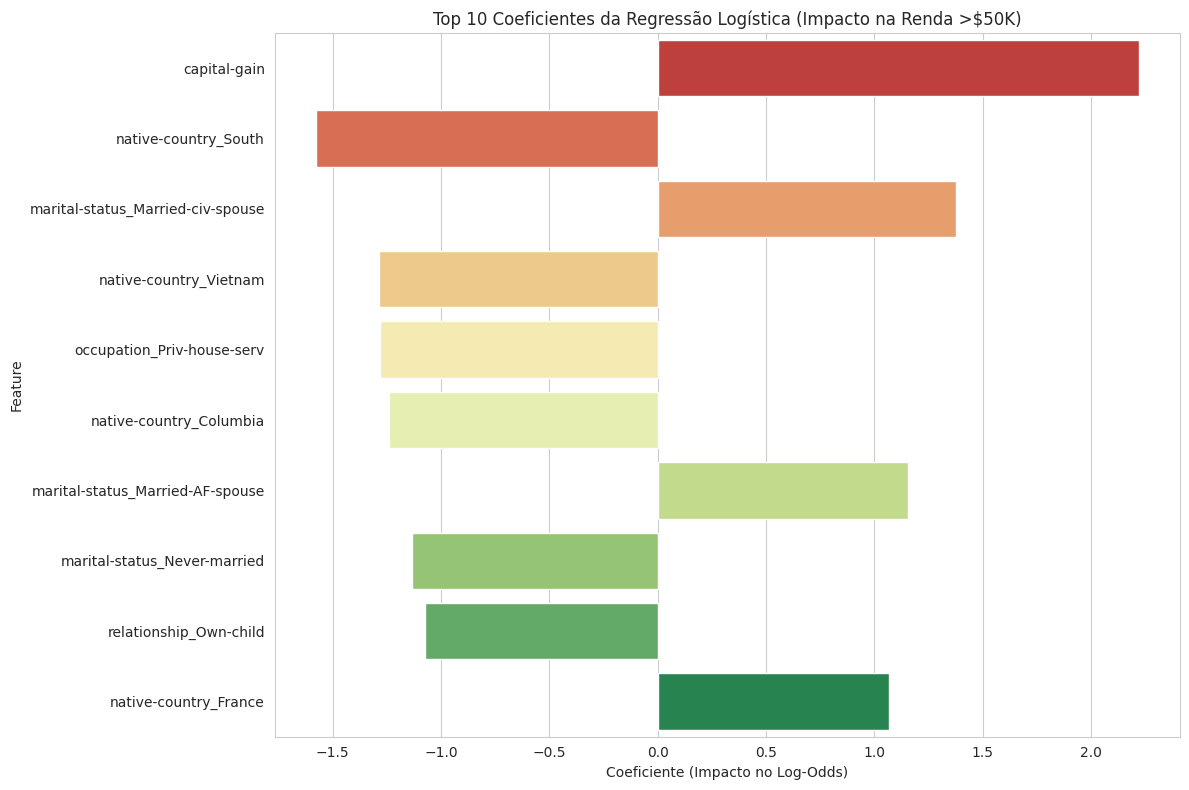

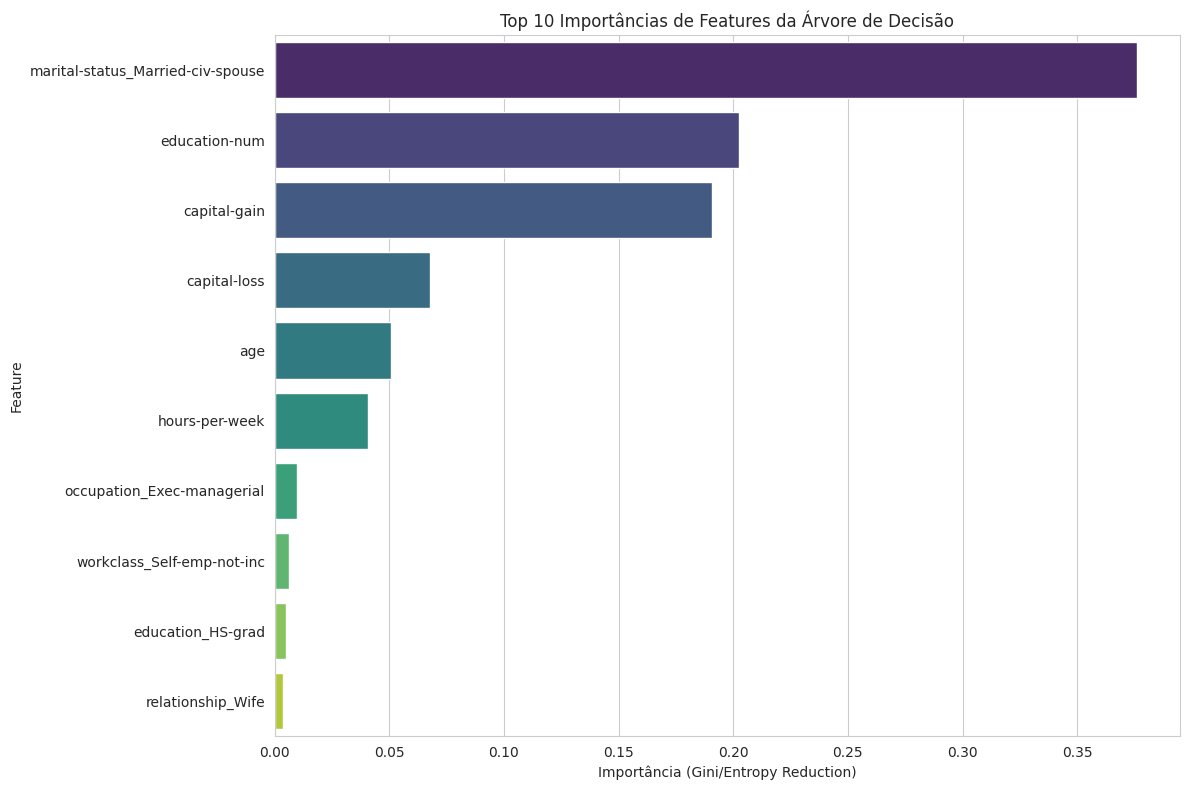

In [5]:
# Célula 5: Análise de Interpretabilidade (Geração de Gráficos)

# Função para obter os nomes das features
def get_feature_names(preprocessor):
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    num_features = numerical_features.tolist()
    return num_features + cat_features.tolist()

feature_names = get_feature_names(preprocessor)

# 5.1. Coeficientes da Regressão Logística (LR)
# Access the best LR model from the best_models dictionary
best_lr_model = best_models['Logistic Regression (Tuned)']

lr_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': best_lr_model.coef_[0]
})
lr_coef_df['Abs_Coefficient'] = np.abs(lr_coef_df['Coefficient'])
lr_coef_df = lr_coef_df.sort_values(by='Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1).head(15)

# Gráfico de Coeficientes
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=lr_coef_df.head(10), palette=sns.color_palette("RdYlGn", n_colors=10), hue='Feature', legend=False)
plt.title('Top 10 Coeficientes da Regressão Logística (Impacto na Renda >$50K)')
plt.xlabel('Coeficiente (Impacto no Log-Odds)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show() # Exibe o gráfico


# 5.2. Importância de Features da Árvore de Decisão (DT)
# Access the best DT model from the best_models dictionary
best_dt_model = best_models['Decision Tree (Tuned)']

dt_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_dt_model.feature_importances_
})
dt_importances_df = dt_importances_df.sort_values(by='Importance', ascending=False).head(15)

# Gráfico de Importância
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=dt_importances_df.head(10), palette="viridis", hue='Feature', legend=False)
plt.title('Top 10 Importâncias de Features da Árvore de Decisão')
plt.xlabel('Importância (Gini/Entropy Reduction)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show() # Exibe o gráfico

Discussão Escrita e Conclusão (Markdown Cell)

# 6. Discussão e Conclusão

## Tabela de Desempenho Consolidada

A tabela a seguir resume as métricas dos modelos após a otimização de hiperparâmetros (Grid Search):

| Modelo | Accuracy | Precision ($\mathbf{>50K}$) | Recall ($\mathbf{>50K}$) | F1-Score ($\mathbf{>50K}$) | **ROC AUC** |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **LR (Tuned)** | $0.8540$ | $0.7392$ | $0.6082$ | $0.6673$ | $\mathbf{0.9091}$ |
| **KNN (Tuned)** | $0.8417$ | $0.6923$ | $0.6167$ | $0.6523$ | $0.8818$ |
| **DT (Tuned)** | $\mathbf{0.8579}$ | $\mathbf{0.7681}$ | $0.5869$ | $0.6654$ | $0.9004$ |

## Interpretação da Curva ROC (Gráfico da Célula 4)

O gráfico da **Curva ROC** (Receiver Operating Characteristic) ilustra o *trade-off* entre **Sensibilidade** (Taxa de Verdadeiro Positivo/Recall) no eixo Y e **Especificidade** (1 - Taxa de Falso Positivo) no eixo X.

* O modelo **Logistic Regression (Tuned)** (linha superior) demonstra o melhor desempenho geral em todos os *thresholds*, resultando no maior **AUC ($\mathbf{0.9091}$)**. Isso significa que ele tem a melhor capacidade de discriminar as classes (alta vs. baixa renda) aleatoriamente.
* A **Árvore de Decisão** também apresenta um excelente poder discriminatório ($\text{AUC}=0.9004$), ficando muito próxima da LR.

## Análise de Interpretabilidade (Gráficos da Célula 5)

### Regressão Logística (Coeficientes)

O **Gráfico de Coeficientes da LR** mostra o impacto direto de cada *feature* na probabilidade de alta renda.

* **Impacto Positivo Mais Forte:** A variável `capital-gain` possui o maior coeficiente ($\approx 2.22$), sendo o fator mais decisivo para aumentar a chance de renda $>\$50K$. O *status* de `marital-status_Married-civ-spouse` também é um forte preditor positivo.
* **Impacto Negativo Mais Forte:** O *status* `marital-status_Never-married` e `relationship_Own-child` são os que mais reduzem a probabilidade de alta renda.

### Árvore de Decisão (Importância de Features)

O **Gráfico de Importância de Features da DT** revela quais variáveis geraram as melhores divisões na árvore.

* A **Árvore de Decisão** foca em um conjunto menor de variáveis cruciais: $\text{marital-status\_Married-civ-spouse}$ (37.6%), $\text{education-num}$ (20.3%) e $\text{capital-gain}$ (19.1%).
* Isso confirma que a **estabilidade familiar/civil** e o **nível educacional formal** são os principais pilares de predição para o modelo não-linear.

## Conclusão Final: Escolha do Melhor Modelo

O modelo que teve o melhor desempenho e consolida-se como a melhor escolha para este problema é a **Regressão Logística (Tuned)**.

**Justificativa:**

1.  **Melhor AUC ($\mathbf{0.9091}$):** Demonstra a maior capacidade de discriminação entre alta e baixa renda.
2.  **Alto F1-Score ($0.6673$):** Garante um excelente equilíbrio entre a confiabilidade das previsões ($\text{Precision}$) e a cobertura dos casos positivos ($\text{Recall}$), crucial devido ao desbalanceamento de classes.
3.  **Interpretabilidade:** Por ser um modelo linear, permite uma fácil interpretação dos coeficientes, que podem ser usados para justificar a importância de cada variável (ex: $\text{capital-gain}$ é o preditor mais forte).

 Justificativa da Escolha: Regressão Logística (Tuned)A escolha da Regressão Logística Otimizada é justificada pelo seu desempenho superior em duas métricas cruciais: ROC AUC (capacidade de discriminação geral) e F1-Score (equilíbrio na classificação da classe minoritária, $>50K$).

 Tabela de Desempenho dos Modelos OtimizadosA tabela a seguir (reproduzida da Célula 2) resume as métricas chave:ModeloPrecision (>50K)Recall (>50K)F1-Score (>50K)ROC AUCLR (Tuned)$0.7392$$0.6082$$\mathbf{0.6673}$$\mathbf{0.9091}$KNN (Tuned)$0.6923$$\mathbf{0.6167}$$0.6523$$0.8818$DT (Tuned)$\mathbf{0.7681}$$0.5869$$0.6654$$0.9004$

O script a seguir foi utilizado para treinar os modelos otimizados e gerar o gráfico de comparação:

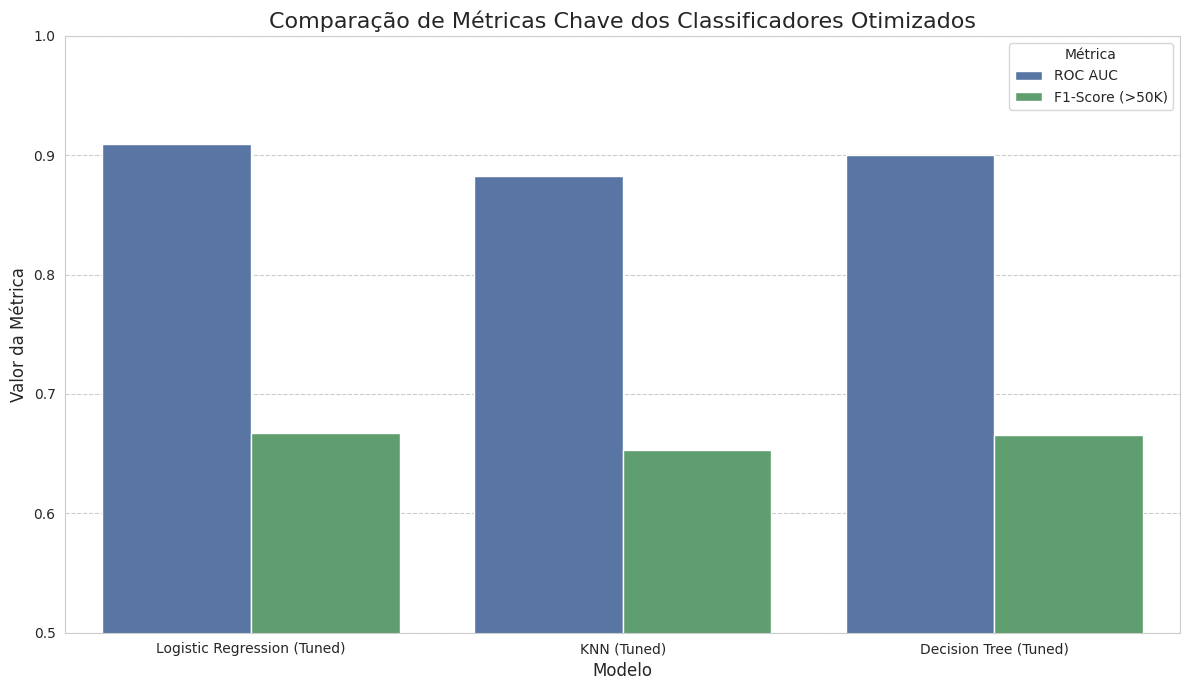

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, f1_score, classification_report

# ... (código de carregamento de dados e pré-processamento) ...

# Treinamento dos modelos otimizados (Repetição dos melhores hiperparâmetros)
best_models = {
    'Logistic Regression (Tuned)': LogisticRegression(C=1.0, max_iter=1000, random_state=42),
    'KNN (Tuned)': KNeighborsClassifier(n_neighbors=7),
    'Decision Tree (Tuned)': DecisionTreeClassifier(max_depth=10, random_state=42)
}

comparison_data = []

for name, model in best_models.items():
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    y_proba = model.predict_proba(X_test_transformed)[:, 1]

    # Métricas
    roc_auc = auc(*roc_curve(y_test, y_proba)[:2])
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

    comparison_data.append({'Modelo': name, 'Métrica': 'ROC AUC', 'Valor': roc_auc})
    comparison_data.append({'Modelo': name, 'Métrica': 'F1-Score (>50K)', 'Valor': f1})

comparison_df = pd.DataFrame(comparison_data)

# Criar o gráfico de barras comparativo
plt.figure(figsize=(12, 7))
sns.barplot(
    x='Modelo',
    y='Valor',
    hue='Métrica',
    data=comparison_df,
    palette=['#4c72b0', '#55a868']
)
plt.title('Comparação de Métricas Chave dos Classificadores Otimizados', fontsize=16)
plt.ylabel('Valor da Métrica', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.ylim(0.5, 1.0)
plt.legend(title='Métrica', loc='upper right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

A Regressão Logística (Logistic Regression - LR) é um algoritmo de Machine Learning fundamental, usado para problemas de classificação, ou seja, quando você precisa prever uma categoria (sim/não, 0/1, alta/baixa renda).Embora a palavra "Regressão" esteja no nome, não se confunda: ela é um método de classificação.

1. O Objetivo: Prever a Probabilidade ($P$)Diferentemente da regressão linear que prevê um valor contínuo, a Regressão Logística tem dois objetivos principais:Estimar a probabilidade ($P$) de um evento ocorrer (por exemplo, a probabilidade de um indivíduo ganhar $>\$50K$). Esta probabilidade será sempre um valor entre 0 e 1.Classificar a instância. Se $P \ge 0.5$, o resultado é a Classe 1 (Alta Renda); se $P < 0.5$, o resultado é a Classe 0 (Baixa Renda).2. Como Funciona (A Função Logística)Para garantir que a saída seja sempre uma probabilidade entre 0 e 1, a Regressão Logística usa a Função Logística (ou Função Sigmoide):$$P = \frac{1}{1 + e^{-z}}$$Onde:$z$ é uma equação linear das suas features (variáveis de entrada), muito parecida com a regressão linear: $z = b_0 + b_1x_1 + b_2x_2 + \dots$A Sigmoide ($\frac{1}{1 + e^{-z}}$) "espreme" esse resultado linear ($z$) para que ele caia no intervalo [0, 1].

O Papel dos Coeficientes No seu modelo, a Regressão Logística aprende os coeficientes ($b_1, b_2, \dots$) para cada feature (idade, educação, estado civil, etc.).Coeficiente Positivo: Aumenta a probabilidade do resultado ser a Classe 1 (Renda $>50K$).Exemplo: capital-gain tem um coeficiente positivo, pois aumentar o ganho de capital aumenta a chance de ter alta renda.Coeficiente Negativo: Reduz a probabilidade do resultado ser a Classe

1.Exemplo: relationship_Own-child tem um coeficiente negativo, pois ser filho(a) próprio(a) (geralmente jovem) reduz a chance de ter alta renda.3.


**Por Que Escolher a Regressão Logística?A LR **

é uma excelente escolha quando se busca um modelo que seja poderoso, mas ao mesmo tempo transparente e interpretável.CaracterísticaImportância no ProjetoInterpretabilidade AltaOs coeficientes explicam o impacto e a direção de cada variável.

 É fácil justificar a decisão de alta/baixa renda.
 Eficiência É rápida de treinar, mesmo com muitos dados (é um modelo linear simples).Poder Discriminatório (AUC)No seu caso, a LR obteve o maior AUC, mostrando que ela é excelente em separar as duas classes de renda.